---------------
---------------
# Character Recognition using optical character recognition(OCR)

## Sections
### 1. Packages
### 2. Datasets
### 3. ResNet Model
### 4. Model Training
### 5. Model Testing
### 6. Character Recognition from Image

---------------
---------------

---------------
---------------
## 1 - Packages
---------------
---------------


In [1]:
#  packages
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import imutils
from imutils import build_montages
import numpy as np
import argparse
import cv2
import tensorflow.keras as keras

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

---------------
---------------
## 2 - Datasets
---------------
---------------


In [8]:
## Functions to Load the datasets
# load the data set containing the english alphabet
def load_alpha_dataset(dataset):
    data = []
    labels = []
    
    for row in open(dataset):
        #parse the rows, seperated by comma
        row = row.split(",")
        label = int(row[0])
        image = np.array([int(x) for x in row[1:]], dtype="uint8")
        
        # according to data set description, the images are in greyscale and
        # of size 28x28 representing the 784 pixels. The image needs to be translated
        # from a single row to a 28x28 matrix represnting the character.
        image = image.reshape((28,28))
        
        data.append(image)
        labels.append(label)
        
    # convert to NumPy Array
    data = np.array(data, dtype="float32")
    labels = np.array(labels, dtype="int")
    
    return(data, labels)

# load the data set containing numbers
def load_number_dataset():
    
    #download dataset
    ((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
    data = np.vstack([trainData, testData])
    labels = np.hstack([trainLabels, testLabels])

	# return a 2-tuple of the MNIST data and labels
    return (data, labels)

In [10]:
#import data sets
(data_letters, labels_letters) = load_alpha_dataset("datasets/A_Z Handwritten Data.csv")
(data_numbers, labels_numbers) = load_number_dataset()
print("Datasets loaded")

KeyboardInterrupt: 

In [4]:
# Instantiate training variables
BS = 128        #batch size
EPOCHS = 50
INIT_LR = 0.1       #learning rate

labels_letters += 10        #add 10 to all letters so they do not conflict with numbers

#stack the data and labels for letters and numbers
data = np.vstack([data_letters, data_numbers])
labels = np.hstack([labels_letters, labels_numbers])

#convert images from 28x28 to 32x32
data = [cv2.resize(image, (32,32)) for image in data]
data = np.array(data, dtype="float32")
data = np.expand_dims(data, axis=-1)
data /= 255.0

le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)
classTotals = labels.sum(axis=0)
classWeight = {}

for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]


In [5]:
#split the data into training and testing set. 80% train, 20% test
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=13)
print("Dataset successfully split")

---------------
---------------
## 3 - ResNet Model
---------------
---------------


In [6]:
#ResNet deepNN . Sourced from https://github.com/jrosebr1. 
def residual_module(data, K, stride, chanDim, red=False,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# the shortcut branch of the ResNet module should be
		# initialize as the input (identity) data
		shortcut = data

		# the first block of the ResNet module are the 1x1 CONVs
		bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(data)
		act1 = Activation("relu")(bn1)
		conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act1)

		# the second block of the ResNet module are the 3x3 CONVs
		bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv1)
		act2 = Activation("relu")(bn2)
		conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
			padding="same", use_bias=False,
			kernel_regularizer=l2(reg))(act2)

		# the third block of the ResNet module is another set of 1x1
		# CONVs
		bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv2)
		act3 = Activation("relu")(bn3)
		conv3 = Conv2D(K, (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act3)

		# if we are to reduce the spatial size, apply a CONV layer to
		# the shortcut
		if red:
			shortcut = Conv2D(K, (1, 1), strides=stride,
				use_bias=False, kernel_regularizer=l2(reg))(act1)

		# add together the shortcut and the final CONV
		x = add([conv3, shortcut])

		# return the addition as the output of the ResNet module
		return x

def deepNN_build(width, height, depth, classes, stages, filters,
		reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"):
		# initialize the input shape to be "channels last" and the
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# set the input and then apply a BN followed by CONV
		inputs = Input(shape=inputShape)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(inputs)
		x = Conv2D(filters[0], (3, 3), use_bias=False,
			padding="same", kernel_regularizer=l2(reg))(x)

		# loop over the number of stages
		for i in range(0, len(stages)):
			# initialize the stride, then apply a residual module
			# used to reduce the spatial size of the input volume
			stride = (1, 1) if i == 0 else (2, 2)
			x = residual_module(x, filters[i + 1], stride,
				chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

			# loop over the number of layers in the stage
			for j in range(0, stages[i] - 1):
				# apply a ResNet module
				x = residual_module(x, filters[i + 1],
					(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

		# apply BN => ACT => POOL
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = AveragePooling2D((8, 8))(x)

		# softmax classifier
		x = Flatten()(x)
		x = Dense(classes, kernel_regularizer=l2(reg))(x)
		x = Activation("softmax")(x)

		# create the model
		model = Model(inputs, x, name="resnet")

		# return the constructed network architecture
		return model

model = deepNN_build(32, 32, 1, len(le.classes_), (3, 3, 3),
	(64, 64, 128, 256), reg=0.0005)


---------------
---------------
## 4 - Model Training
---------------
---------------


In [7]:
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

augment = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    fill_mode="nearest")

History = model.fit(
	augment.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,
	class_weight=classWeight,
	verbose=1)

print("Training complete")

Epoch 1/50
2765/2765 [==============================] - 166s 57ms/step - loss: 3.8124 - accuracy: 0.7600 - val_loss: 0.5361 - val_accuracy: 0.8893
Epoch 2/50
2765/2765 [==============================] - 158s 57ms/step - loss: 0.9764 - accuracy: 0.9241 - val_loss: 0.5493 - val_accuracy: 0.8855
Epoch 3/50
2765/2765 [==============================] - 161s 58ms/step - loss: 0.8774 - accuracy: 0.9317 - val_loss: 0.5471 - val_accuracy: 0.8861
Epoch 4/50
2765/2765 [==============================] - 153s 55ms/step - loss: 0.8330 - accuracy: 0.9363 - val_loss: 0.5830 - val_accuracy: 0.8703
Epoch 5/50
2765/2765 [==============================] - 147s 53ms/step - loss: 0.7868 - accuracy: 0.9406 - val_loss: 0.5142 - val_accuracy: 0.8995
Epoch 6/50
2765/2765 [==============================] - 147s 53ms/step - loss: 0.7688 - accuracy: 0.9427 - val_loss: 0.4666 - val_accuracy: 0.9215
Epoch 7/50
2765/2765 [==============================] - 147s 53ms/step - loss: 0.7465 - accuracy: 0.9452 - val_loss: 0

In [12]:
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [label_names for label_names in labelNames]

predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

# save the model
model_file_name = "OCR.h5"
model.save("model_file_name")
print("Model saved as %s", model_file_name)

              precision    recall  f1-score   support

           0       0.43      0.49      0.46      1381
           1       0.97      0.99      0.98      1575
           2       0.94      0.97      0.95      1398
           3       0.98      0.99      0.99      1428
           4       0.92      0.98      0.95      1365
           5       0.70      0.92      0.79      1263
           6       0.96      0.99      0.97      1375
           7       0.97      1.00      0.98      1459
           8       0.95      0.99      0.97      1365
           9       0.98      0.98      0.98      1392
           A       1.00      0.99      0.99      2774
           B       0.98      0.99      0.99      1734
           C       0.99      0.98      0.99      4682
           D       0.91      0.98      0.94      2027
           E       0.99      0.99      0.99      2288
           F       0.97      1.00      0.98       232
           G       0.97      0.94      0.96      1152
           H       0.98    

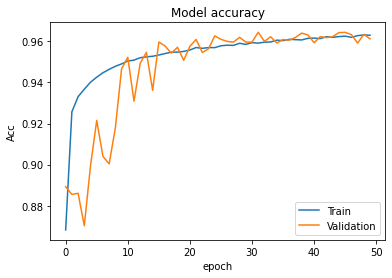

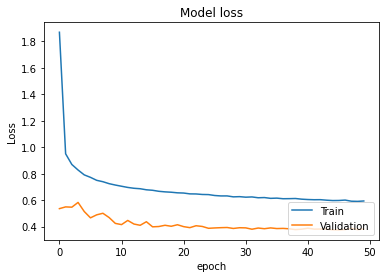

In [13]:
# create and save plots of accuary and loss
N = np.arange(0, EPOCHS)

#accurary
plt.figure()
plt.plot(N, History.history['accuracy'])
plt.plot(N, History.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig("accuracy_plot.png")

#loss
plt.figure()
plt.plot(N, History.history['loss'])
plt.plot(N, History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig("loss_plot.png")

---------------
---------------
## 5 - Model Testing
---------------
---------------


In [7]:
# initialize list of images for montage output
images = []

# randomly select characters to test. 
for i in np.random.choice(np.arange(0, len(testY)), size=(100,)):
	
	probs = model.predict(testX[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]

	# grab the image from the testing dataset
	image = (testX[i] * 255).astype("uint8")

	# label the image with green for correct
	color = (0, 255, 0)					 

	# test the label to see if the label is correct
	if prediction[0] != np.argmax(testY[i]):
		#if label is incorrect, change label to red
		color = (0, 0, 255)

	
	# merge the three channels into one image
	image = cv2.merge([image] * 3)
	#resize image to make it easier to read 
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	#add text to image in upper left corner
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_TRIPLEX, 0.75,
		color, 2)

	# add the image to list of output images
	images.append(image)

# construct the montage for the images
montage = build_montages(images, (96, 96), (10, 10))[0]

# save the output montage
cv2.imwrite("test_montage.png", montage)
print("Montage saved")

NameError: name 'testY' is not defined

---------------
---------------
## 6 - Character Recognition from Image
---------------
---------------


In [2]:
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours

#reload the model saved earlier if new session
try:
    if(model != NULL):
        print("model already loaded")
except:
    model = load_model("OCR.h5")
    print("model loaded")

model loaded


In [3]:
#load the test image(s) & convert to grayscale
image = cv2.imread("Images/Hand_write.jpg")
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_blur = cv2.GaussianBlur(image_gray, (5, 5), 0)

#find edges and sort contours
image_edge = cv2.Canny(image_blur, 30, 150)
contour = cv2.findContours(image_edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = imutils.grab_contours(contour)
contour = sort_contours(contour, method="left-to-right")[0]

#list to hold the characters
chars = []

In [4]:
# loop over the contours
for conts in contour:

	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(conts)

	if (w >= 15 and w <= 150) and (h >= 15 and h <= 120):
		# grab region of interest from greyscale image
		roi = image_gray[y:y + h, x:x + w]

		# use threshold so image appears as white character on a
		# black background
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(thresh_H, thresh_W) = thresh.shape

		# resize along width
		if thresh_W > thresh_H:
			thresh = imutils.resize(thresh, width=32)
            
		# resize along height
		else:
			thresh = imutils.resize(thresh, height=32)

		(thresh_H, thresh_W) = thresh.shape
		X_new = int(max(0, 32 - thresh_W) / 2.0)
		Y_new = int(max(0, 32 - thresh_H) / 2.0)

		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=Y_new, bottom=Y_new,
			left=X_new, right=X_new, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))

		# prepare the padded image for classification via our
		# handwriting OCR model
		padded_image = padded.astype("float32") / 255.0
		padded_image = np.expand_dims(padded_image, axis=-1)

		# update our list of characters that will be OCR'd
		chars.append((padded_image, (x, y, w, h)))

print("All images processed")

All images processed


In [5]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")

# OCR the characters using our handwriting recognition model
preds = model.predict(chars)

# redefine the list of label names incase whole notebook
# is not being run
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

In [6]:
# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes):

	# assign index the highest predicted value and 
	# prob/label of that index
	index = np.argmax(pred)
	prob = pred[index]
	label = labelNames[index]

	# draw the prediction on the image
	cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
	cv2.putText(image, label, (x - 10, y - 10),
		cv2.FONT_HERSHEY_TRIPLEX, 1.2, (0, 255, 0), 2)

#save predicted image results
cv2.imwrite("test_results.png", image)
print("Image saved")

Image saved
